# Word-Level 번역기 만들기(Neural Machine Translation (seq2seq) Tutorial)

# Seq2Seq 모델 설계 및 훈련 프로세스
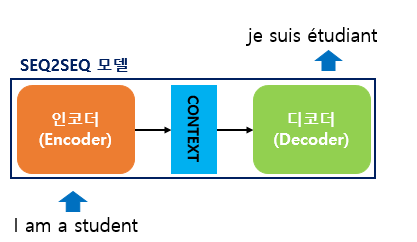


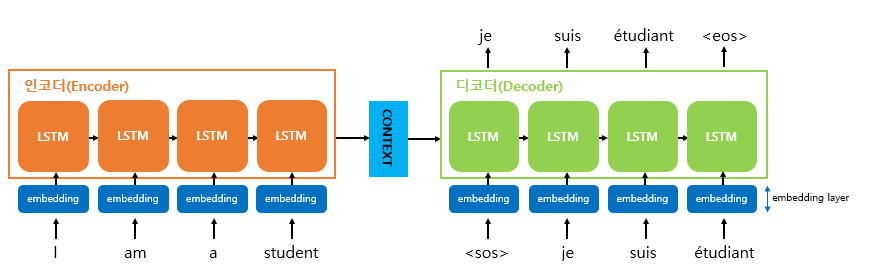
## Seq2Seq(Sequence to Sequence) 모델
- 인코더(Encoder)**와 디코더(Decoder) 두 부분으로 구성.
- 하나의 시퀀스(예: 입력 문장)를 받아, 다른 시퀀스(예: 출력 문장)로 변환
- 인코더는 순환 신경망(RNN), LSTM, GRU와 같은 셀을 사용하여 입력 시퀀스를 처리
- 마지막 시점의 은닉 상태와 셀 상태가 컨텍스트 벡터(Context Vector)로 디코더에 전달
- 디코더는 인코더에서 전달받은 컨텍스트 벡터(마지막 시점의 은닉 상태와 셀 상태)를 초기 상태로 사용하여 시작
- `<sos>`토큰(시작 토큰)이 디코더의 입력으로 들어가며 첫 번째 단어 예측
- 이전 시점에서 예측한 단어를 다음 시점의 입력으로 사용하면서 한 번에 한 단어씩 예측.
- `<eos>`토큰이 나오면 종료



## 0. 데이터
- **프랑스어 영어 병렬 코퍼스 사용**

## 1. 전처리
- **악센트 제거**: 프랑스어 문장에서 악센트 제거
- **구두점 분리**: 단어와 구두점 사이에 공백 추가
- **디코더의 입력과 레이블 분리**: 디코더 입력에 `<sos>` 추가, 레이블에 `<eos>` 추가

## 2. 데이터 토크나이저 적용 및 패딩
- **토크나이저**: 영어와 프랑스어 문장에 대해 각각 토크나이저를 적용해 단어를 정수로 인코딩
- **패딩**: 시퀀스 길이를 동일하게 맞추기 위해 패딩 적용
- **단어 집합 형성 및 <u>단어 <-> 인덱스</u> dict 형성**

## 3. 모델 설계
### 3.1 인코더 (Encoder)
- **입력층** → **임베딩 층** 변환
- **LSTM layer**를 통과
- 마지막 시점의 **은닉 상태**와 **셀 상태**를 **Context Vector**로 생성

### 3.2 디코더 (Decoder)
- **입력층** (`<sos>`로 시작하는) → **임베딩 층** 변환
- **LSTM layer**를 통과
- **Dense 층**을 통과하며 Softmax 활성화 함수 사용

## 4. 모델 컴파일 및 훈련
- **Optimizer**: Adam 옵티마이저 사용
- **Loss Function**: `sparse_categorical_crossentropy` 사용
- **훈련 데이터**와 **검증 데이터**를 사용하여 모델 훈련
s>`로 시작하는) → **임베딩 층** 변환
- **LSTM layer**를 통과
- **Dense 층**을 통과하며3.2 디코더 (Decoder) Softmax4. 모델 컴파일 및 훈련
- **Optimizer**: Adam 옵티마이저 사용
- **Loss Function**: `sparse_categorical_crossentropy` 사용
- **훈련 데이터**와 **검증 데이터**를 사용하여 모델 훈련


### <b>파일 다운로드</b>

In [56]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

def download_zip(url, output_path):
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"ZIP file downloaded to {output_path}")
    else:
        print(f"Failed to download. HTTP Response Code: {response.status_code}")

url = "http://www.manythings.org/anki/fra-eng.zip"
output_path = "fra-eng.zip"
download_zip(url, output_path)

path = os.getcwd()
zipfilename = os.path.join(path, output_path)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)


ZIP file downloaded to fra-eng.zip


### <b>데이터 전처리</b>

In [57]:
def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
  # 악센트 제거 함수 호출
  sent = to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백 추가.
  # ex) "I am a student." => "I am a student ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent


#### <b>unicodedata.normalize('NFD', s):</b>

> 이 함수는 유니코드 정규화를 수행합니다. NFD(Normalization Form Decomposition)는 문자를 기본 문자와 악센트 기호로 분해합니다.
예를 들어, 'é'는 NFD로 분해하면 'e'와 '́ '로 나뉩니다.


#### <b> ''.join(...): </b>

> 분해된 문자를 다시 하나의 문자열로 결합합니다.

#### <b> if unicodedata.category(c) != 'Mn': </b>

> - unicodedata.category(c)는 각 문자의 유니코드 카테고리를 반환합니다.
> - 'Mn'은 비합성 문자(Mark, Nonspacing)를 의미하며, 주로 악센트와 같은 기호를 가리킵니다. 이 조건은 악센트 기호를 걸러내기 위해 사용됩니다.
즉, 악센트 같은 비합성 문자는 문자열에 포함하지 않습니다

In [58]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))


전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [64]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target


#### <b>교사 강요가 필요한 이유<b>
훈련 과정에서 디코더가 잘못된 예측을 할 때마다 그 값을 입력으로 사용하면, 모델은 잘못된 패턴을 학습할 수 있다. 이로 인해 모델은 효율적으로 학습하지 못하고, 정확도가 낮아지거나 훈련 시간이 길어진다. 이를 해결하기 위해 훈련 과정에서 디코더가 이전 시점의 예측값이 아니라 실제값(즉, 정답)을 다음 시점의 입력으로 사용하도록 강제하느 것이 효율적이다.


#### <b>단점</b> 
교사 강요 덕분에 모델이 훈련 과정에서 빠르고 안정적으로 학습할 수 있지만, 훈련과 테스트 간의 차이로 인해 실제 성능이 훈련 중에 보였던 성능보다 낮을 수도 있다. 이를 **노출 편향(Exposure Bias)**이라고 부르며, 교사 강요의 단점으로 지적된다.

In [ ]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

In [94]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")


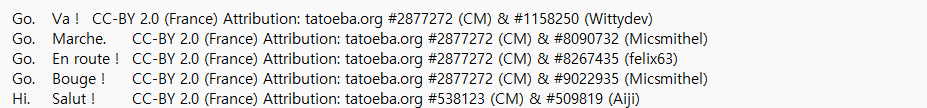

In [95]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)


인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


In [96]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))


영어 단어 집합의 크기 : 4485, 프랑스어 단어 집합의 크기 : 7878


In [97]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word


In [98]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [15307 15523 17300 ... 24598 15587 10486]


In [99]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]


In [100]:
encoder_input[30997]

array([165,  15, 241,   1,   0,   0,   0])

In [102]:
decoder_input[30997]

array([  2, 478,  32, 170,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

In [104]:
decoder_target[30997]

array([478,  32, 170,   1,   3,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0])

In [105]:
n_of_val = int(33000*0.1)
print('검증 데이터의 개수 :',n_of_val)


검증 데이터의 개수 : 3300


In [106]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


In [107]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)


훈련 source 데이터의 크기 : (29700, 7)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 7)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


In [108]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model


In [109]:
embedding_dim = 64
hidden_units = 64


In [110]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장


In [111]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])


In [112]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)


Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - acc: 0.6048 - loss: 5.0670 - val_acc: 0.6313 - val_loss: 1.9316
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - acc: 0.6819 - loss: 1.8445 - val_acc: 0.7453 - val_loss: 1.6749
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - acc: 0.7471 - loss: 1.6326 - val_acc: 0.7543 - val_loss: 1.5455
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - acc: 0.7588 - loss: 1.5046 - val_acc: 0.7683 - val_loss: 1.4487
Epoch 5/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - acc: 0.7713 - loss: 1.4130 - val_acc: 0.7785 - val_loss: 1.3629
Epoch 6/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - acc: 0.7845 - loss: 1.3178 - val_acc: 0.7962 - val_loss: 1.2712
Epoch 7/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - acc: 0.8015 - loss: 1.2205 - val_acc: 0.8088 - val_loss: 1.2049
Epoch 8/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - acc: 0.8136 - loss: 1.1511 - val_acc: 0.8168 - val_loss: 1.1487
Epoch 9/50
233/233 ━━━━━━━━━━━━━━━━━━━━

In [113]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [114]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence


In [115]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence


In [116]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
입력문장 : i ll be back soon . 
정답문장 : je serai vite de retour . 
번역문장 : je serai vite de retour . 
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
입력문장 : he owes me one . 
정답문장 : il m en doit une . 
번역문장 : il m en faut . 
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1